# Concentration Tracker for fluvial erosion, transport, & deposition using SpaceLargeScaleEroder
Written by: Laurent Roberge

Last edited: Sept. 23, 2024

## Purpose
This notebook is the User Manual for the fluvial concentration tracker described in Roberge et al., (2025). This notebook contains the code to reproduce the fluvial examples shown in Roberge et al, (2025) with necessary comments and directions so that users may adapt these examples for their own experimentation.

## Introduction
In this notebook, we introduce the ``ConcentrationTrackerForSpace`` Landlab component. This is a companion component to the ``SpaceLargeScaleEroder``, which simulates fluvial erosion, transport, and deposition. ``ConcentrationTrackerForSpace`` uses the sediment fluxes from ``SpaceLargeScaleEroder`` to calculate a mass balance and redistribute sediment tracer concentrations across a Landlab grid. 

We walk through two examples of the ``ConcentrationTrackerForSpace``: first, a 1-dimensional stream channel cross-section that shows a pulse of tracer sediment that is transported downstream, then a 2-dimensional erosional catchment that shows how fluvial erosion, transport, and deposition affects the fraction of bed sediment sourced from a specific region.

## Background
There are many Landlab model components that simulate fluvial erosion and transport processes. The ``ConcentrationTracker`` is designed to couple with one specific component, ``SpaceLargeScaleEroder``. ``SpaceLargeScaleEroder`` is an update to the Stream Power With Alluvium Conservation and Entrainment (SPACE) component (Shobe et al., 2017). It is a mass conservative erosion-deposition fluvial sediment transport model that acts on a mobile sediment layer (i.e., channel bed sediment) and an underlying erodible bedrock layer. Mass is conserved both for sediment in the water column and for sediment and rock on the channel bed. 

We refer the reader to Shobe et al. (2017) for more information on the development of the equations that are contained in ``SpaceLargeScaleEroder``. The ``ConcentrationTracker`` uses a mass balance foundation and couples with the fluvial component. We refer the reader to Roberge et al. (2025) for the details on the numerical implementation and coupling of the ``ConcentrationTracker`` with the ``SpaceLargeScaleEroder``.

## Running the code
First we import the required Python and Landlab libraries.

In [39]:
# Import
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from landlab import RasterModelGrid, imshow_grid, imshowhs_grid, NodeStatus
from landlab.components import (PriorityFloodFlowRouter,
                                SpaceLargeScaleEroder,
                                ConcentrationTrackerForSpace,
                                ChannelProfiler,
                                )

In [40]:
# This allows plots show up in the notebook
%matplotlib inline

### 1-dimensional example
We begin with a 1-dimensional fluvial example that shows the movement of a pulse of tracer sediment as it travels downstream due to fluvial erosion, transport, and deposition processes. This example is illustrated in Section 3 and Figure 4 of Roberge et al. (2025).

### Define input parameters 
Below, we define the input parameters that govern the size of the model grid and the timescale over which the model runs.
We also define the parameters governing the three Landlab model components that make up the model (the ``PriorityFloodFlowRouter``, ``SpaceLargeScaleEroder``, and ``ConcentrationTrackerForSpace``). Finally, we define the rock uplift rate, which governs the steady-state erosion rate and therefore how tall and steep our landscape will become.

In [41]:
# Grid parameters
nrows = 3
ncols = 22
dx = 100                # metres
dy = dx                 # metres

# Time parameters
dt = 10                # years
total_t = 5000        # years
print_interval = 50   # years

# SpaceLargeScaleEroder parameters
phi = 0.0               # - (porosity of bed sediment)
fraction_fines = 0.0    # -
settling_velocity = 1   # m/y  
# NOTE: a settling velocity of 1 m/y will reproduce the example shown in Figure __a of Roberge et al., 202X.
# Changing settling velocity to 10 m/y and re-running the code will reproduce the example shown in Figure __b.

# ConcentrationTracker parameters
# No parameters necessary for the moment

# Rock uplift rate that drives fluvial erosion 
uplift_rate = 0.005    # m/y

# Some additional definitions and calculations
# -----------------------------------------------------------------------------
uplift_per_step = uplift_rate*dt
ndt = int(total_t // dt)  # number of time steps
outlet_node = ncols  # location where water and sediment leave the grid
node_next_to_outlet = outlet_node+1
years_elapsed = 0
vert_exag_factor = 2
# -----------------------------------------------------------------------------

### Generating the model grid and fields
Here, we generate a model grid that uses the grid parameters we defined above. In this case, we have a grid that is 3 rows tall and 20 columns long. The top and bottom rows are made up of boundary nodes, as are the left and right columns. We will close all of these (i.e., not allow flux across them), then open up only the leftmost node so that sediment can flux out of the domain. The leftmost node will be the outlet of the channel. Since the top and bottom rows are closed, we have a single middle row on which fluvial processes operate. This way, we generate a "1-dimensional" channel profile on a 2-dimensional grid.

We then add grid fields to store the data required to run the numerical model. We generate grid fields for soil depth, bedrock elevation, topographic elevation, and two concentration fields: one for concentration in sediment and another for concentration in bedrock. Concentrations are unit agnostic and can be defined by the user as any mass concentration (e.g., $kg/m^3$) or mass-like concentration (e.g., for a cosmogenic nuclide of interest: $atoms/m^3$). In the examples below, we assume all material has the same density and differs only in colour. Therefore, the tracer sediment "concentration" values can be thought of as a mass fraction.

In [42]:
# %% Generate model grid
mg1 = RasterModelGrid((nrows, ncols), dx)
mg1.axis_units = ('m', 'm')

# Set boundary conditions
mg1.set_status_at_node_on_edges(right=NodeStatus.CLOSED,
                               top=NodeStatus.CLOSED,
                               left=NodeStatus.CLOSED,
                               bottom=NodeStatus.CLOSED)
mg1.status_at_node[outlet_node] = NodeStatus.FIXED_VALUE

# Add fields (soil depth, bedrock elevation, topographic elevation)
h_soil = mg1.add_zeros('soil__depth', at='node', units= ['m','m'])
elev_br = mg1.add_zeros('bedrock__elevation', at='node', units= ['m','m'])
elev_topo = mg1.add_zeros('topographic__elevation', at='node', units= ['m','m'])
mg1.at_node['topographic__elevation'][:] += mg1.at_node['bedrock__elevation']
mg1.at_node['topographic__elevation'][:] += mg1.at_node['soil__depth']

# Add concentration fields
C_sed = mg1.add_zeros('sediment_property__concentration', at='node', units='kg/m^3')
C_br = mg1.add_zeros('bedrock_property__concentration', at='node', units='kg/m^3')

# Some additional definitions for later visualization
# -----------------------------------------------------------------------------
nframes = 1 + (total_t // print_interval)
nframe = 0
core_ids = np.append(outlet_node, mg1.core_nodes)
distance = mg1.node_x[core_ids]
C_values = np.zeros([nframes,len(core_ids)])
br_elevs = np.zeros([nframes,len(core_ids)])
soil_elevs = np.zeros([nframes,len(core_ids)])
C_values[nframe,:] = C_sed[core_ids]
br_elevs[nframe,:] = elev_br[core_ids]
soil_elevs[nframe,:] = elev_br[core_ids]+(h_soil[core_ids]*vert_exag_factor)
# -----------------------------------------------------------------------------

### Instantiating model components
Here, we instantiate three model components using the parameters defined at the beginning of the script. The ``PriorityFloodFlowRouter`` calculates flow direction, accumulation, water discharge, and drainage area, the ``SpaceLargeScaleEroder`` uses the output of the flow router to solve for fluvial erosion, transport, and deposition, and the ``ConcentrationTrackerForSpace`` solves for the concentration of our tracer property in the mobile sediment layer. These calculations will be made each timestep using the input parameters.

In [43]:
# %% Instantiate model components
fr = PriorityFloodFlowRouter(mg1)

sp = SpaceLargeScaleEroder(mg1,
                           phi=phi,
                           F_f=fraction_fines,
                           v_s=settling_velocity,
                           )

ct = ConcentrationTrackerForSpace(mg1,
                                  phi=phi,
                                  fraction_fines=fraction_fines,
                                  settling_velocity=settling_velocity,
                                  )

### Running the numerical model loop
We will run the model for 5,000 years to generate a steady state channel profile. Within each iteration of the model loop, we first add rock uplift by increasing the elevation of the bedrock. Then, we ensure that topographic elevation matches this change. Then, we run the ``PriorityFloodFlowRouter`` and the ``SpaceLargeScaleEroder`` for one timestep. For this set-up period there is no need to track concentrations, so don't run the ``ConcentrationTrackerForSpace``. Finally, we print the model progress and an estimate of the remaining runtime. This model run should take less than a minute.

In [44]:
# %% Run model to equilibrium

# Set initial timestamp (used to print progress updates)
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg1.at_node['bedrock__elevation'][mg1.core_nodes] += uplift_per_step
    mg1.at_node['topographic__elevation'][:] = (mg1.at_node["bedrock__elevation"]
                                               + mg1.at_node["soil__depth"])
    
    # Run PriorityFloodFlowRouter and SpaceLargeScaleEroder
    fr.run_one_step()
    sp.run_one_step(dt)
        
    # The model has now finished one iteration (i.e., acted over one timestep). 
    # Nothing below is required for the model to function. It is just used to print 
    # progress and save data for later visualization.
    # -----------------------------------------------------------------------------
    # Print progress
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed:", round(years_elapsed/1000),
              "ka (", round(years_elapsed*100/total_t,2), "%)     ",
              "Runtime remaining:", runtime_remaining_mins, "min  ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = elev_br[core_ids]+(h_soil[core_ids]*vert_exag_factor)
        br_elevs[nframe,:] = elev_br[core_ids]
        C_values[nframe,:] = C_sed[core_ids]
    # -----------------------------------------------------------------------------

### Visualization
Here, we generate an empty plot onto which we will render an animation of the 1-dimensional hillslope profile as it evolves through time.

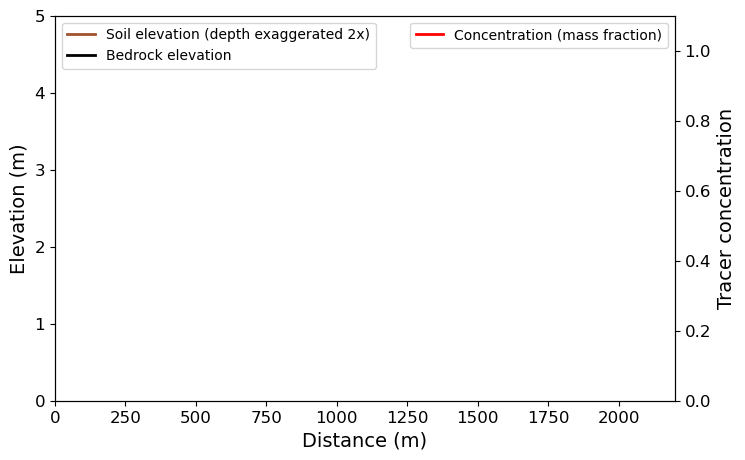

In [45]:
# Set up a background frame for plotting
ymax = 5  # Maximum y-axis value for elevation profile
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot()
ax2 = ax1.twinx()

# Set up the axes 
ax1.set_xlabel('Distance (m)', fontsize=14, color='black')
ax1.set_ylabel('Elevation (m)', fontsize=14, color='black')
ax1.set_xlim((0,ncols*dx))           
ax1.set_ylim((0,ymax))
ax1.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Tracer concentration', fontsize=14, color='black')
ax2.set_ylim((0,1.1))
ax2.tick_params(axis='y', labelcolor='black')    

# Create empty objects for parts of the plot that will change in the animation. 
# They will be given new values for each frame.
txt_title = ax1.set_title('')
soil_elev_line, = ax1.plot([], [], 'sienna', lw=2)
bedrock_elev_line, = ax1.plot([], [], 'k', lw=2)
concentration_line, = ax2.plot([], [], 'r', lw=2)

ax1.legend(['Soil elevation (depth exaggerated 2x)','Bedrock elevation'],loc="upper left")
ax2.legend(['Concentration (mass fraction)'],loc="upper right")

# Define animation function to be called sequentially to make an animation showing changes over time.
def drawframe(n):
    soil_elev_line.set_data(distance,soil_elevs[n,:])
    bedrock_elev_line.set_data(distance,br_elevs[n,:])
    concentration_line.set_data(distance,C_values[n,:])
    txt_title.set_text("Years elapsed: " + str(n*print_interval))
    return (soil_elev_line,bedrock_elev_line,concentration_line,txt_title)


### Plot the channel profile
Below, we plot the channel profile using our plotting function. The left y-axis shows elevation. There is a bedrock channel with a maximum elevation of approximately 35 (black line) covered by a mobile sediment layer about 6 cm deep (brown line, with 20x vertical exaggeration so that the line can be seen separately from the bedrock elebation). The right y-axis shows our tracer concentration in this mobile regolith layer. Since we haven't added any tracer yet, it is zero throughout the profile.

In [46]:
# Plot the hillslope profile (this may take a minute to render)
anim = animation.FuncAnimation(fig, drawframe, frames=nframes, interval=100, repeat=False, blit=True)
HTML(anim.to_html5_video())

### Running the model with a spike of tracer concentration
Now, we add a spike of concentration to act as a tracer. We will change the ``sediment_property__concentration`` value from 0 to 1 at the 1,500 m mark (node #37).

In [47]:
# Add tracer to node #37
mg1.at_node['sediment_property__concentration'][:] = 0    # Think of this as a mass fraction (here, there is no tracer sediment)
mg1.at_node['sediment_property__concentration'][37] = 1   # Think of this as a mass fraction (here, all the sediment is tracer sediment)

# Set up new time parameters for this run
dt = 1               # years
total_t = 300       # years
print_interval = 1   # years

# Some additional definitions
# -----------------------------------------------------------------------------
years_elapsed = 0
uplift_per_step = uplift_rate*dt
ndt = int(total_t // dt)

# For later visualization:
nframes = 1 + (total_t // print_interval)
nframe = 0
core_ids = np.append(outlet_node, mg1.core_nodes)
distance = mg1.node_x[core_ids]
C_at_outlet = np.zeros([nframes])
C_values = np.zeros([nframes,len(core_ids)])
br_elevs = np.zeros([nframes,len(core_ids)])
soil_elevs = np.zeros([nframes,len(core_ids)])
C_at_outlet[nframe] = C_sed[node_next_to_outlet]
C_values[nframe,:] = C_sed[core_ids]
br_elevs[nframe,:] = elev_br[core_ids]
soil_elevs[nframe,:] = elev_br[core_ids]+(h_soil[core_ids]*vert_exag_factor)
# -----------------------------------------------------------------------------

We shorten the total runtime to 1000 years to see the downstream movement of the tracer over that time period. Note that the ``ConcentrationTracker`` components do not use the typical Landlab run method of ``run_one_step(dt)``. Instead, the ``start_tracking()`` and ``stop_tracking(dt)`` methods are used before and after the flux component so that the ``ConcentrationTracker`` only tracks changes caused by that one instance of landscape change. This becomes very important when coupling multiple flux components to generate complex landscapes with many processes acting on them.

In [48]:
# Set initial timestamp (used to print progress updates)
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg1.at_node['bedrock__elevation'][mg1.core_nodes] += uplift_per_step
    mg1.at_node['topographic__elevation'][:] = (mg1.at_node["bedrock__elevation"]
                                               + mg1.at_node["soil__depth"])
    
    # Run PriorityFloodFlowRouter, SpaceLargeScaleEroder, and ConcentrationTrackerForSpace
    fr.run_one_step()
    ct.start_tracking()
    sp.run_one_step(dt)
    ct.stop_tracking(dt)
        
    # Print progress and save data for later visualization:
    # -----------------------------------------------------------------------------
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed: ", years_elapsed,
              " (", round(years_elapsed*100/total_t,2), "%)",
              "   Runtime remaining: ", runtime_remaining_mins, " min   ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = elev_br[core_ids]+(h_soil[core_ids]*vert_exag_factor)
        br_elevs[nframe,:] = elev_br[core_ids]
        C_values[nframe,:] = C_sed[core_ids]
        C_at_outlet[nframe] = C_sed[node_next_to_outlet]
    # -----------------------------------------------------------------------------

### Plot the channel profile through time

Below, we see a gif of the channel profile as it changes through the first 400 years of the model run. The tracer concentration in the mobile sediment layer is depicted as a red line with values corresponding to the right y-axis. It starts as a spike near the headwaters of the channel. The concentration spike quickly diminishes as sediment is eroded and transported downstream. This animation shows that although the channel profile is at equilibrium and there is no net change to sediment depth or topography through time, the water column is actively interacting with the mobile sediment layer, eroding and transporting sediment downstream, while replenishing eroded material by depositing sediment from upstream.

Several frames from this animation are used to make Figure 4 of Roberge et al. (2025).

In [49]:
# Render and display the animation (this may take a minute to render)
anim = animation.FuncAnimation(fig, drawframe, frames=101, interval=40, repeat=False, blit=True)
HTML(anim.to_html5_video())

### Plot the concentration at the outlet of the channel through time
We cut off the animation above at 100 years so that the rendering doesn't take too long. Below is a timeseries of the concentration that leaves the domain at the outlet of the channel for the duration of the 500 year model run. The concentration values peak at around 20 years and take around 200 years to approach zero again. Increasing settling velocity would cause sediment to travel a shorter distance in the water column before depositing, resulting in a tracer peak that takes longer to arrive at the outlet.

This is included in Figure 4 of Roberge et al. (2025).

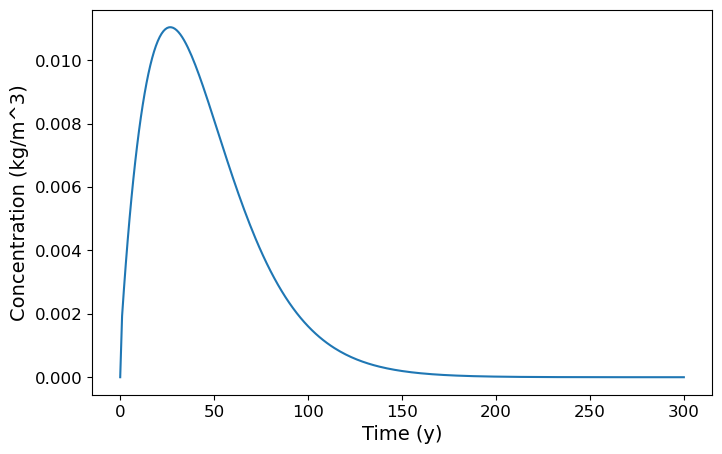

In [50]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot()
plt.plot(np.array(range(nframes))*print_interval,C_at_outlet)
ax.set_xlabel('Time (y)', fontsize=14, color='black')
ax.set_ylabel('Concentration (kg/m^3)', fontsize=14, color='black')
plt.show()

### 2-dimensional example
Now, we show a 2-dimensional fluvial catchment example in which the bedrock is composed of two regions of different lithology, one "red" and one "white". We use the ``bedrock_property__concentration`` and ``sediment_property__concentration`` to represent a fraction of red material in the bedrock and sediment. A value of 1 indicates 100% red material, while 0 indicates 0% red material. 

We will set up the catchment to be much larger than the 1-dimensional example. The number of rows and columns need to change to increase the size of the domain. We will also reduce the bedrock and sediment erodibility to generate grerater relief. We will also open an outlet in the southwest corner of the domain.

This example is illustrated in Section 4 and Figure 6 of Roberge et al. (2025).

In [51]:
# New grid parameters
nrows = 50
ncols = 50

# Time parameters
dt = 100                 # years
total_t = 500000         # years
print_interval = 2000    # years

# SpaceLargeScaleEroder parameters
sed_erodibility = 2e-4   # 1/~m~
br_erodibility = 1e-4    # 1/~m~
phi = 0.0                # - 
fraction_fines = 0.0     # -
settling_velocity = 1    # m/y  

# Rock uplift rate that drives fluvial erosion 
uplift_rate = 0.001      # m/yr

# Some additional definitions and calculations
# -----------------------------------------------------------------------------
uplift_per_step = uplift_rate*dt
ndt = int(total_t // dt)
years_elapsed = 0
outlet_node = 0
node_next_to_outlet = ncols+1
outlet_node_ws1 = 1828
outlet_node_ws2 = 1325
outlet_node_ws3 = 509
# -----------------------------------------------------------------------------

In [52]:
# %% Generate model grid
mg2 = RasterModelGrid((nrows, ncols), dx)
mg2.axis_units = ('m', 'm')

# Set boundary conditions
mg2.set_status_at_node_on_edges(right=NodeStatus.CLOSED,
                               top=NodeStatus.CLOSED,
                               left=NodeStatus.CLOSED,
                               bottom=NodeStatus.CLOSED)
mg2.status_at_node[outlet_node] = NodeStatus.FIXED_VALUE

# Add fields (soil depth, bedrock elevation, topographic elevation)
np.random.seed(1)
elev_br = mg2.add_zeros('bedrock__elevation', at='node', units= ['m','m'])
elev_br += np.random.rand(mg2.number_of_nodes) / 10
elev_br[outlet_node] = 0
h_soil = mg2.add_zeros('soil__depth', at='node', units= ['m','m'])
elev_topo = mg2.add_zeros('topographic__elevation', at='node', units= ['m','m'])
mg2.at_node['topographic__elevation'][:] += mg2.at_node['bedrock__elevation']
mg2.at_node['topographic__elevation'][:] += mg2.at_node['soil__depth']

# Add concentration fields
C_sed = mg2.add_zeros('sediment_property__concentration', at='node', units='kg/m^3')
C_br = mg2.add_zeros('bedrock_property__concentration', at='node', units='kg/m^3')

### Instantiating model components
We need to re-instantiate the model components for the new grid.

In [53]:
# %% Instantiate model components
fr = PriorityFloodFlowRouter(mg2)

sp = SpaceLargeScaleEroder(mg2,
                           K_sed=sed_erodibility,
                           K_br=br_erodibility,
                           phi=phi,
                           F_f=fraction_fines,
                           v_s=settling_velocity,
                           )

ct = ConcentrationTrackerForSpace(mg2,
                                  phi=phi,
                                  fraction_fines=fraction_fines,
                                  settling_velocity=settling_velocity,
                                  )

### Running the numerical model loop
We will run the model for 500,000 years to generate a steady state fluvial catchment. This model run may take 5 minutes or more.

In [54]:
# %% Run model to equilibrium
# Set initial timestamp (used to print progress updates)
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg2.at_node['bedrock__elevation'][mg2.core_nodes] += uplift_per_step
    mg2.at_node['topographic__elevation'][:] = (mg2.at_node["bedrock__elevation"]
                                               + mg2.at_node["soil__depth"])
    
    # Run PriorityFloodFlowRouter, SpaceLargeScaleEroder, and ConcentrationTrackerForSpace
    fr.run_one_step()
    ct.start_tracking()
    sp.run_one_step(dt)
    ct.stop_tracking(dt)
    
    # Print progress and save data for later visualization:
    # -----------------------------------------------------------------------------
    current_time = time.time()
    years_elapsed = i*dt
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed:", round(years_elapsed/1000),
              "ka (", round(years_elapsed*100/total_t,2), "%)     ",
              "Runtime remaining:", runtime_remaining_mins, "min  ", end='\r')
    # -----------------------------------------------------------------------------

### Plot a 2-dimensional hillshade plan view of the catchment
Below we see a hillshade of the catchment overlain by a topographic colormap to indicate elevation.

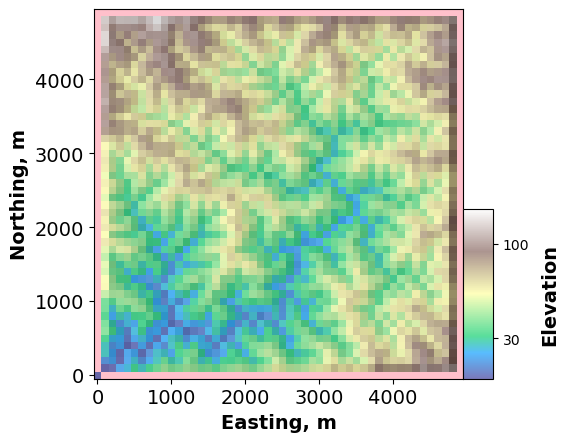

In [55]:
# Visualize the hillshade overlain by a topographic elevation colomap.
imshowhs_grid(mg2, 'topographic__elevation', azdeg=260, altdeg=45, cmap='terrain',
              plot_type='Drape1', drape1="topographic__elevation", default_fontsize=14,
              alpha=0.65, var_name='Elevation', #limits=(0,0.75),
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right',
              bbox_to_anchor=(1.08,0), cbar_height=1.7, cbar_width=0.3, 
              colorbar_label_y=8, color_for_closed='pink',
              )
plt.show()

### Running the model with coloured bedrock regions
Now, we add colour to two different regions of the catchment colour concentration in the bedrock. We will change the ``bedrock_property__concentration`` value from 0 to 1 for all nodes that lie in the northern third of the catchment (that is, for all nodes with a ``node_y`` value of 3,200 m and more). The plot below overlays the ``bedrock_property__concentration`` on top of the hillshade to clearly show the two bedrock regions. The mobile sediment layer (``sediment_property__concentration``) has not been changed, so this figure only represents the bedrock underlying the mobile bed sediment. We will evolve the landscape by running ``SpaceLargeScaleEroder`` to erode bedrock and transport and deposit sediment downstream. The ``ConcentrationTracker`` component calculates the concentration mass balance in both bedrock and sediment, so the surface sediment will gain colour as the coloured region is eroded. This will allow us to see the surface expression of the eroded bedrock.

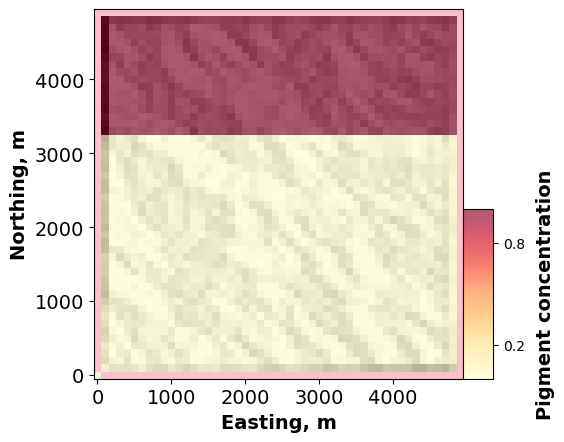

In [56]:
# Add colour to the bedrock in one area of provenance
mg2.at_node['sediment_property__concentration'][:] = 0
mg2.at_node['bedrock_property__concentration'][:] = 0
mg2.at_node['bedrock_property__concentration'][mg2.node_y>3200] = 1

# Visualize the hillshade with bedrock colour concentration overlain.
imshowhs_grid(mg2, 'topographic__elevation', azdeg=115, cmap='YlOrRd',
              plot_type='Drape1', drape1="bedrock_property__concentration", default_fontsize=14,
              alpha=0.65, var_name='Pigment concentration', limits=(0,1),
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right',
              bbox_to_anchor=(1.08,0), cbar_height=1.7, cbar_width=0.3, 
              colorbar_label_y=8, color_for_closed='pink',
              )
plt.show()

### Add sub-watershed stream channels
Here we add a plan view of three sub-watershed stream channels to the above map.

We instantiate and run the ``ChannelProfiler`` to extract channels from four different locations: the main channel that exits the catchment in the southwest corner, and three sub-watershed channels that have differing amounts of their catchment area within the red bedrock region. These channels are shown in the plot below. They flow from the headwaters (in white) to the outlet point at which concentration is measured (in dark blue). The northernmost of these is 100% within the red bedrock region, the middle one has about 40% source area within the red bedrock region, and the southern sub-watershed has only about 1% source area within the red bedrock region. Once we run the model, this difference in percent area should be expressed by the concentration in the material that exits each sub-watershed.

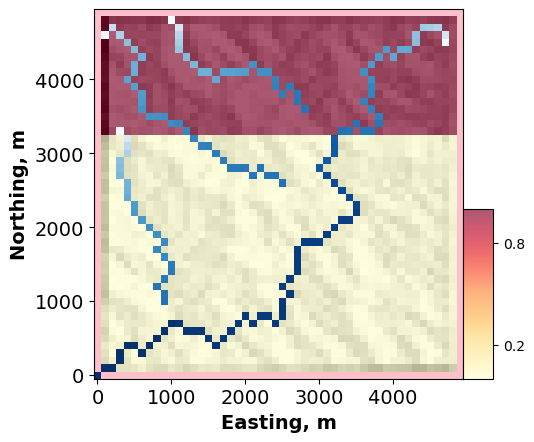

In [57]:
prf = ChannelProfiler(mg2, number_of_watersheds=4, outlet_nodes=[outlet_node,outlet_node_ws1,outlet_node_ws2,outlet_node_ws3,])
prf.run_one_step()

channel_mask = np.isin(mg2.nodes.flatten(),np.concatenate(prf.nodes))
drainage_area = np.zeros(np.shape(channel_mask))
drainage_area[channel_mask] = np.log(mg2.at_node['drainage_area'][channel_mask])

imshowhs_grid(mg2, 'topographic__elevation', azdeg=115, cmap='YlOrRd', plot_type='Drape2', 
              drape1="bedrock_property__concentration", alpha=0.65, var_name='Pigment concentration',
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right', bbox_to_anchor=(1.08,0),
              cbar_height=1.7, cbar_width=0.3, colorbar_label_y=8, color_for_closed='pink', default_fontsize=14,
              drape2=drainage_area, thres_drape2=0.01, cmap2='Blues',
              )
plt.show()

Here, we update a few parameters and then run the model loop.

In [58]:
# Set up new time parameters for this run
dt = 1                 # years
total_t = 1000         # years
print_interval = 10    # years

# Some additional definitions
# -----------------------------------------------------------------------------
uplift_per_step = uplift_rate*dt
ndt = int(total_t // dt)
years_elapsed = 0

# For later visualization:
nframes = 1 + (total_t // print_interval)
nframe = 0
main_profile_ids = prf.nodes[0]
main_profile_distances = prf.distance_along_profile[0]
C_at_outlet = np.zeros(nframes)
C_values = np.zeros([nframes,len(main_profile_ids)])
br_elevs = np.zeros([nframes,len(main_profile_ids)])
soil_elevs = np.zeros([nframes,len(main_profile_ids)])
C_at_outlet[nframe] = mg2.at_node['sediment_property__concentration'][node_next_to_outlet]
C_values[nframe,:] = mg2.at_node['sediment_property__concentration'][main_profile_ids]
br_elevs[nframe,:] = mg2.at_node['bedrock__elevation'][main_profile_ids]
soil_elevs[nframe,:] = mg2.at_node['bedrock__elevation'][main_profile_ids]+(mg2.at_node['soil__depth'][main_profile_ids]*vert_exag_factor)
# -----------------------------------------------------------------------------

In [59]:
# Run model
start_time = time.time()

for i in range(ndt+1):
    # Add uplift, update topographic elevation to match bedrock and soil depths
    mg2.at_node['bedrock__elevation'][mg2.core_nodes] += uplift_per_step
    mg2.at_node['topographic__elevation'][:] = (mg2.at_node["bedrock__elevation"]
                                               + mg2.at_node["soil__depth"])
    
    # Run ExponentialWeatherer, DepthDependentDiffuser, and ConcentrationTrackerForDiffusion
    fr.run_one_step()
    ct.start_tracking()
    sp.run_one_step(dt)
    ct.stop_tracking(dt)
    
    # Print progress and save data for later visualization:
    # -----------------------------------------------------------------------------
    current_time = time.time()
    years_elapsed = i*dt   
    if i>0 and years_elapsed % print_interval == 0:
        runtime_remaining = (ndt-i)*(current_time - start_time)/i
        runtime_remaining_mins = round(runtime_remaining/60,2)
        print("Years elapsed: ", years_elapsed,
              " (", round(years_elapsed*100/total_t,2), "%)",
              "   Runtime remaining: ", runtime_remaining_mins, " min   ", end='\r')
        # Save data for plotting
        nframe += 1
        soil_elevs[nframe,:] = mg2.at_node['bedrock__elevation'][main_profile_ids]+(mg2.at_node['soil__depth'][main_profile_ids]*vert_exag_factor)
        br_elevs[nframe,:] = mg2.at_node['bedrock__elevation'][main_profile_ids]
        C_values[nframe,:] = mg2.at_node['sediment_property__concentration'][main_profile_ids]
        C_at_outlet[nframe] = mg2.at_node['sediment_property__concentration'][node_next_to_outlet]
    # -----------------------------------------------------------------------------

Below, we visualize the mobile sediment colour. This is a visual representation of the fraction of sediment that has been sourced from the red bedrock zone. The colour is most prominent in the channels within and just dowsntream of the red bedrock zone. Moving downstream, more and more sediment is sourced from other areas. This dilutes the red colour.

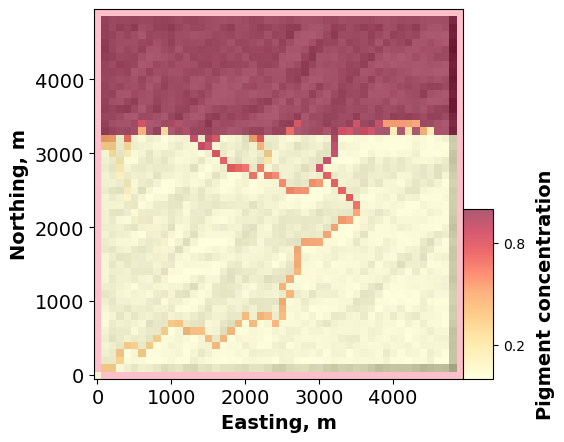

In [60]:
imshowhs_grid(mg2, 'topographic__elevation', azdeg=215, cmap='YlOrRd',
              plot_type='Drape1', drape1="sediment_property__concentration", default_fontsize=14,
              alpha=0.65, var_name='Pigment concentration', limits=(0,1),
              allow_colorbar=True, cbar_or='vertical', cbar_loc='lower right',
              bbox_to_anchor=(1.08,0), cbar_height=1.7, cbar_width=0.3, 
              colorbar_label_y=8, color_for_closed='pink',
              )
plt.show()

### Channel profile visualization
Here, we generate an empty plot onto which we will render a 1-dimensional channel profile of the main channel in the 2-dimensional landscape as it evolves through time. This is similar to that of the 1-dimensional example.

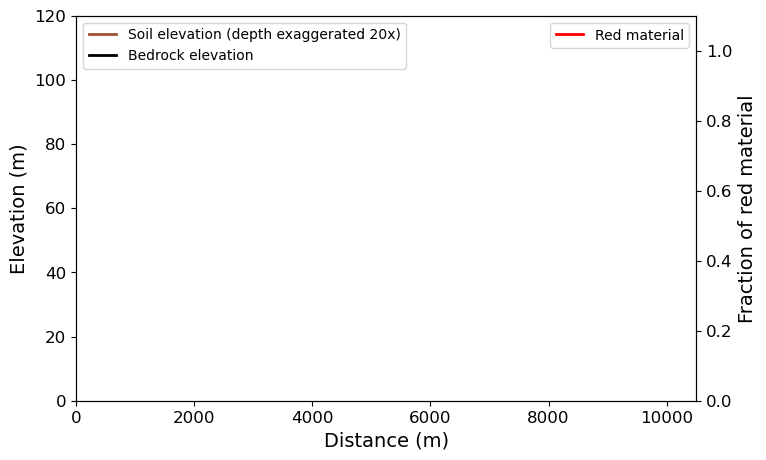

In [61]:
# Set up a background frame for plotting
ymax = 120  # Maximum y-axis value for elevation profile
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot()
ax2 = ax1.twinx()

# Set up the axes 
ax1.set_xlabel('Distance (m)', fontsize=14, color='black')
ax1.set_ylabel('Elevation (m)', fontsize=14, color='black')
ax1.set_xlim((0,ncols*dx*2.1))           
ax1.set_ylim((0,ymax))
ax1.tick_params(axis='y', labelcolor='black')
ax2.set_ylabel('Fraction of red material', fontsize=14, color='black')
ax2.set_ylim((0,1.1))
ax2.tick_params(axis='y', labelcolor='black')    

# Create empty objects for parts of the plot that will change in the animation. 
# They will be given new values for each frame.
txt_title = ax1.set_title('')
soil_elev_line, = ax1.plot([], [], 'sienna', lw=2)
bedrock_elev_line, = ax1.plot([], [], 'k', lw=2)
concentration_line, = ax2.plot([], [], 'r', lw=2)

ax1.legend(['Soil elevation (depth exaggerated 20x)','Bedrock elevation'],loc="upper left")
ax2.legend(['Red material'],loc="upper right")

# Define animation function to be called sequentially to make an animation showing changes over time.
def drawframe(n):
    soil_elev_line.set_data(main_profile_distances,soil_elevs[n,:])
    bedrock_elev_line.set_data(main_profile_distances,br_elevs[n,:])
    concentration_line.set_data(main_profile_distances,C_values[n,:])
    txt_title.set_text("Years elapsed: " + str(n*print_interval))
    return (soil_elev_line,bedrock_elev_line,concentration_line,txt_title)


### Plot the main channel profile through time

Below, we see a gif of the main channel profile. The gif shows changes through the first 1,000 years of the model run. The colour concentration in the channel bed is depicted as a red line with values corresponding to the right y-axis. The red bedrock region at the headwaters of the channel begins to erode immediately. Material eroded from this bedrock is then transported quickly downstream and deposited all along the channel to the outlet, increasing the concentration values in the bed sediment. The main channel is met by several tributaries along the way that increase or decrease concentration values depending on the sediment they transport. For example, at around the 1,500 m and 5,500 m, sudden drops in concentration indicate tributaries diluting the concentration value by providing sediment with a much lower fraction of red material than the main channel.

In [62]:
# Render and display the animation (this may take a minute to render)
C_values[:,0] = np.nan
anim = animation.FuncAnimation(fig, drawframe, frames=101, interval=40, repeat=False, blit=True)
HTML(anim.to_html5_video())

### Plot the concentration at the outlet of the channel over time
Below is a timeseries of the concentration that leaves the domain at the outlet of the channel for the duration of the 1,000 year model run. The concentration values rise quickly at first and then begin to plateau until they reach their final value by around 400-500 years. The final value for each sub-catchment is also shown.

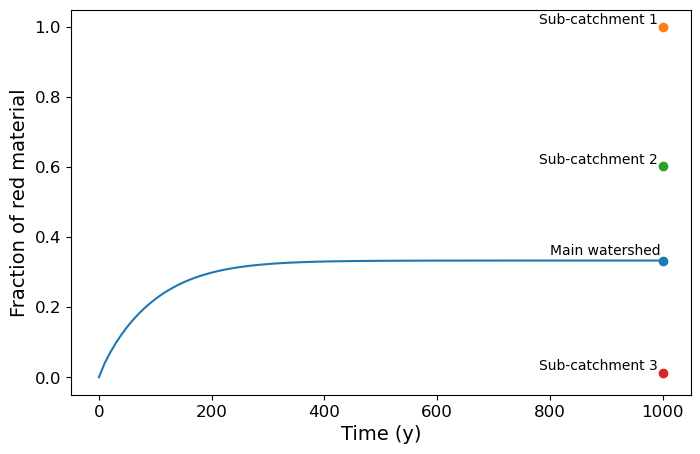

In [63]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot()
plt.plot(np.array(range(nframes))*print_interval,C_at_outlet)
plt.scatter(total_t,mg2.at_node['sediment_property__concentration'][node_next_to_outlet])
plt.scatter(total_t,mg2.at_node['sediment_property__concentration'][outlet_node_ws1])
plt.scatter(total_t,mg2.at_node['sediment_property__concentration'][outlet_node_ws2])
plt.scatter(total_t,mg2.at_node['sediment_property__concentration'][outlet_node_ws3])
ax.annotate('Main watershed', (800, 0.35))
ax.annotate('Sub-catchment 1', (780, 1.01))
ax.annotate('Sub-catchment 2', (780, 0.61))
ax.annotate('Sub-catchment 3', (780, 0.02))
ax.set_xlabel('Time (y)', fontsize=14, color='black')
ax.set_ylabel('Fraction of red material', fontsize=14, color='black')
plt.show()

### References

Shobe, C. M., Tucker, G. E., and Barnhart, K. R. (2017). The SPACE 1.0 model: A Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution. Geoscientific Model Development, 10(12), 4577–4604. https://doi.org/10.5194/gmd-10-4577-2017 

Roberge, L., Gasparini, N., Campforts, B., and Tucker., G. (2025). ____